<a href="https://colab.research.google.com/github/dcpatton/Image-Classification/blob/master/beans_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import random
import pandas as pd

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

# The Data

More about the dataset is here: https://github.com/AI-Lab-Makerere/ibean/

In [2]:
train_ds, val_ds, test_ds = tfds.load('beans', split=['train', 'validation', 'test'], as_supervised=True, try_gcs=True, shuffle_files=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteRD64X0/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteRD64X0/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteRD64X0/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
def normalize_image(image, label):
  image = float(image)/255.
  return image, label

def augment_image(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  return image, label

In [4]:
num_classes = 3
BATCH_SIZE = 16

# train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# The Model

EfficientNet

In [5]:
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GaussianNoise
from tensorflow.keras import Input, Model
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, Rescaling, Resizing, RandomFlip, RandomContrast, RandomZoom

model_url = "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1"
hub_layer = hub.KerasLayer(model_url, trainable=False)

inp = Input(shape=(500, 500, 3))
x = Resizing(528, 528)(inp)
# x = RandomRotation(0.5)(x)
x = RandomFlip(mode='horizontal_and_vertical')(x)
# x = RandomContrast(0.1)(x)
x = RandomZoom(height_factor=0.1, width_factor=0.1)(x)
x = Rescaling(scale=1./255., offset=0.0)(x)
# x = GaussianNoise(stddev=0.2)(x)
x = hub_layer(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs=[inp], outputs=[out])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 500, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 528, 528, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 528, 528, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 528, 528, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 528, 528, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2304)              40960136  
_________________________________________________________________
dropout (Dropout)            (None, 2304)             

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# Training

In [7]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history = model.fit(train_ds, epochs=200, validation_data=val_ds, callbacks=[es])

Epoch 1/200
65/65 [==============================] - 37s 573ms/step - loss: 0.6133 - acc: 0.7495 - val_loss: 0.6675 - val_acc: 0.7368
Epoch 2/200
65/65 [==============================] - 34s 519ms/step - loss: 0.3349 - acc: 0.8598 - val_loss: 0.4604 - val_acc: 0.8571
Epoch 3/200
65/65 [==============================] - 34s 520ms/step - loss: 0.2775 - acc: 0.8897 - val_loss: 0.3080 - val_acc: 0.9323
Epoch 4/200
65/65 [==============================] - 34s 518ms/step - loss: 0.2463 - acc: 0.8994 - val_loss: 0.2517 - val_acc: 0.9474
Epoch 5/200
65/65 [==============================] - 34s 518ms/step - loss: 0.2346 - acc: 0.9120 - val_loss: 0.1931 - val_acc: 0.9398
Epoch 6/200
65/65 [==============================] - 34s 517ms/step - loss: 0.2093 - acc: 0.9101 - val_loss: 0.1857 - val_acc: 0.9323
Epoch 7/200
65/65 [==============================] - 34s 518ms/step - loss: 0.1959 - acc: 0.9188 - val_loss: 0.1638 - val_acc: 0.9398
Epoch 8/200
65/65 [==============================] - 33s 512ms

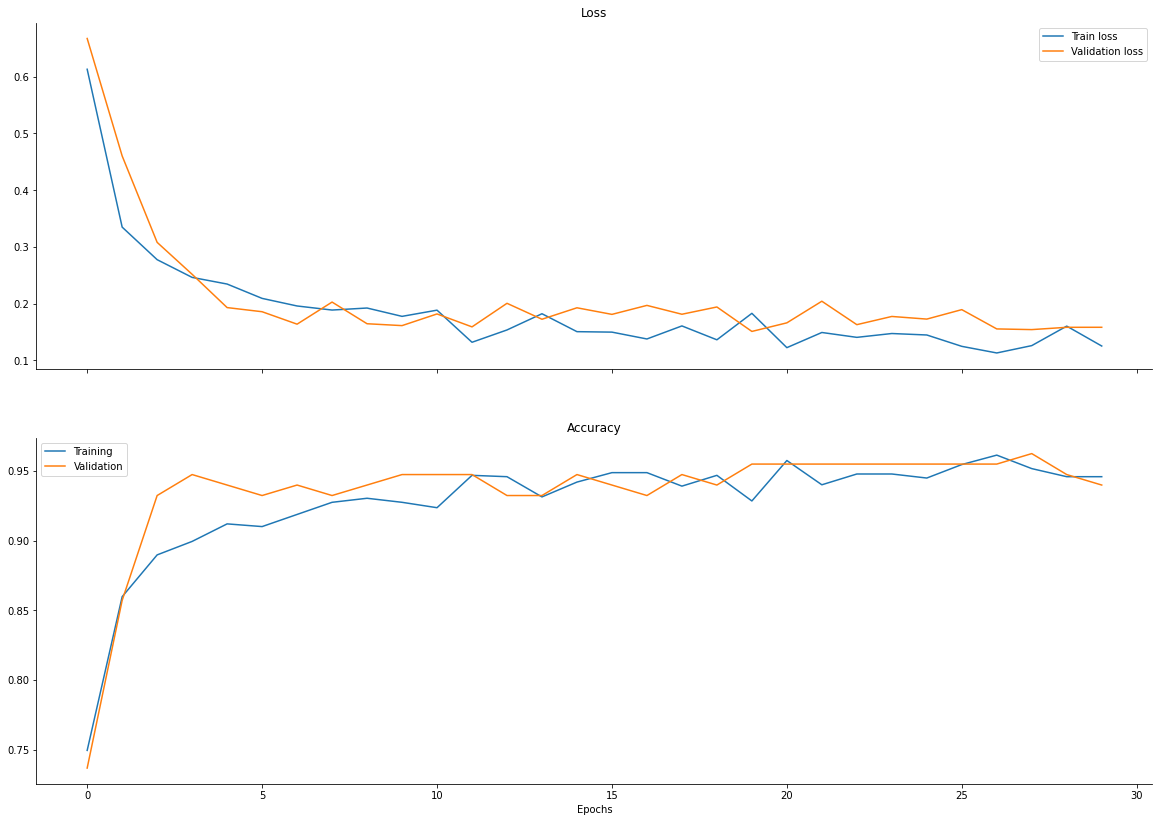

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Training')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Evaluation

In [9]:
model.evaluate(test_ds, verbose=True)

8/8 [==============================] - 3s 400ms/step - loss: 0.1805 - acc: 0.9219


[0.1805415004491806, 0.921875]

* baseline:             loss: 62.7713 - acc: 0.4531
* normalize input:      loss: 0.1355 - acc: 0.9297
* random flips:         **loss: 0.1283 - acc: 0.9609**
* add Dense layer:      loss: 0.1639 - acc: 0.9062
* shuffle files:        loss: 0.1288 - acc: 0.9375
* rotation (0.2):       loss: 0.1811 - acc: 0.9219
* rotation (0.1):       loss: 0.1625 - acc: 0.9453
* resize (528,528,3):   loss: 0.1834 - acc: 0.9375       
* batch_size=16:        loss: 0.1610 - acc: 0.9531
* batch_norm:           loss: 0.1661 - acc: 0.9219
* Dropout(0.2):         loss: 0.1507 - acc: 0.9609
* Dropout(0.5):         loss: 0.1723 - acc: 0.9531
* RandomFlips:          loss: 0.1703 - acc: 0.9531
* GaussianNoise:        loss: 0.3888 - acc: 0.8359
* RandomContrast(0.1):  loss: 0.1537 - acc: 0.9453
* RandomZoom:           loss: 0.1527 - acc: 0.9531
* rotation(0.5):        loss: 0.1810 - acc: 0.9375
* batchnorm again:      loss: 0.1805 - acc: 0.9219

# Summary

I achieved about 96% accuracy on the test set. No doubt futher performance improvements could be attained with fine tuning of the model and hyperparameter optimization (especially of the augmentation factors). Additionally TTA and a ensemble model might be beneficial as well.